<h1> Scaling up ML using Cloud ML Engine </h1>

Adapted from [Notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/cloudmle/cloudmle.ipynb) of Google Coursera Course [Serverless Machine Learning with Tensorflow on Google Cloud Platform](https://www.coursera.org/learn/serverless-machine-learning-gcp/)

In [ ]:
!pip install tensorflow==1.12

In [1]:
import tensorflow as tf
tf.__version__

'1.12.0'

In [2]:
import os
WORKINGDIR = os.getcwd()
folders = WORKINGDIR.split('/')
if folders.pop() == 'notebook':  # or a list: in ['notebook', 'src', etc.]
  WORKINGDIR = '/'.join(folders)
  print("New working directory: {}".format(WORKINGDIR))
else:
  print("Current Working direcotory is kept: {}".format(WORKINGDIR))
os.chdir(WORKINGDIR)

New working directory: /home/enryh/proj_DL_models_and_pipelines_with_GCP


<h2> Environment variables for project and bucket </h2>

Note that:
<ol>
<li> Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page. My dashboard reads:  
     
     Project ID: ml-productive-pipeline-12345
<li> Cloud training often involves saving and restoring model files. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available). A common pattern is to prefix the bucket name by the project id, so that it is unique. Also, for cost reasons, you might want to use a single region bucket. </li>
</ol>

<b>Add all detail in to [config.yaml](../config.yaml) file in main directory. Missing in public repository.


In [39]:
import yaml

with open("config.yaml", "r", encoding = "utf8") as f:
    config = yaml.load(f)
    
print(config)

# # #Create config manually and save as yaml:
# config = {}
# config['project-id'] = 'PROJECT'  # # REPLACE WITH YOUR PROJECT ID
# config['region'] = 'europe-west1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
# config['bucket'] = 'Bucket-name'  # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
# 
# with open("../config_from_python.yaml", 'wb', encoding= 'utf8') as f:
#     yaml.dump(f)

{'project-id': 'ml-productive-pipeline-53122', 'region': 'europe-west1', 'bucket': 'ml-productive-pipeline-53122', 'tf-version': 1.12, 'pkg-name': 'pkg_mnist_fnn'}


TO persistently add variables to the runtime of the datalab kernel, us the build in python function `os.environ`

In [40]:
import os
PROJECT = config['project-id'] 
REGION = config['region'] # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
BUCKET = config['bucket'] # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
PKG_NAME = config['pkg-name']

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = str(config['tf-version'])  # Tensorflow version 1.4 before
os.environ['PKG_NAME'] = config['pkg-name']

Now, you can access the environement variable in the terminal running this datalab session

In [41]:
%%bash
echo $TFVERSION

1.12


In [42]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


Allow the Cloud ML Engine service account to read/write to the bucket containing training data.

In [43]:
%%bash
PROJECT_ID=$PROJECT
AUTH_TOKEN=$(gcloud auth print-access-token)
# echo $AUTH_TOKEN
SVC_ACCOUNT=$(curl -X GET -H "Content-Type: application/json" \
    -H "Authorization: Bearer $AUTH_TOKEN" \
    https://ml.googleapis.com/v1/projects/${PROJECT_ID}:getConfig \
    | python -c "import json; import sys; response = json.load(sys.stdin); \
    print(response['serviceAccount'])")
echo "Current Service Account of VM: $SVC_ACCOUNT"
echo "Authorizing the Cloud ML Service account $SVC_ACCOUNT to access files in Bucket: $BUCKET"
gsutil -m defacl ch -u $SVC_ACCOUNT:R gs://$BUCKET
gsutil -m acl ch -u $SVC_ACCOUNT:R -r gs://$BUCKET  # error message (if bucket is empty) can be ignored
gsutil -m acl ch -u $SVC_ACCOUNT:W gs://$BUCKET

Current Service Account of VM: service-552147390438@cloud-ml.google.com.iam.gserviceaccount.com
Authorizing the Cloud ML Service account service-552147390438@cloud-ml.google.com.iam.gserviceaccount.com to access files in Bucket: ml-productive-pipeline-53122


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   233    0   233    0     0    228      0 --:--:--  0:00:01 --:--:--   228
No changes to gs://ml-productive-pipeline-53122/
No changes to gs://ml-productive-pipeline-53122/mnist.npy
No changes to gs://ml-productive-pipeline-53122/test.tfrecords
No changes to gs://ml-productive-pipeline-53122/train.tfrecords
No changes to gs://ml-productive-pipeline-53122/datalab-backups/europe-west4-a/datalab-henry/content/daily-20190124094427
No changes to gs://ml-productive-pipeline-53122/datalab-backups/europe-west4-a/datalab-henry/content/hourly-20190124094427
No changes to gs://ml-productive-pipeline-53122/datalab-backups/europe-west4-a/datalab-henry/content/weekly-20190124094427
No changes to gs://ml-productive-pipeline-53122/datalab-backups/europe-west4-a/datalab-instance-test/content/daily-20190123104613
No changes to gs://ml-productiv

<h2> Packaging up the code </h2>

Take your code and put into a standard Python package structure, see  <a href="package_ml_engine/mnist_ml_engine.py">model.py</a>

In [44]:
!cat src/$PKG_NAME/model.py

"""
First try to start Cloud ML

References:
Basic reference for packaging the model so that ml-engine can use it:
- https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/cloudmle/taxifare
MNIST-Estimator-Example:
- https://codeburst.io/use-tensorflow-dnnclassifier-estimator-to-classify-mnist-dataset-a7222bf9f940

ipython -i -m src.models.test_model_estimator_api.mnist_ml_engine -- --data_path=data --output_dir=src\models\test_model_estimator_api\trained --train_steps=100
"""

import tensorflow as tf
import numpy as np

from .utils import load_data
###############################################################################
#Factor into config:
N_PIXEL = 784
OUTDIR = 'trained'
USE_TPU = False
EPOCHS = 10

if USE_TPU:
    _device_update = 'tpu'
else:
    _device_update = 'cpu'

IMAGE_SIZE = 28 * 28
NUM_LABELS = 10
BATCH_SIZE = 128
###############################################################################


def parse_images(x):
    retu

In [54]:
!cat src/$PKG_NAME/task.py

"""
Parse arguments and call main function
"""
import os
import argparse
import shutil

from .model import train_and_evaluate

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--data_path',
        help='GCS or local path to training data',
        required=True
    )
    parser.add_argument(
        '--output_dir',
        help='GCS location to write checkpoints and export models',
        required=True
    )
    parser.add_argument(
        '--train_batch_size',
        help='Batch size for training steps',
        type=int,
        default='128'
    )
    parser.add_argument(
        '--train_steps',
        help='Steps to run the training job for',
        type=int,
        default='200'
    )
    parser.add_argument(
        '--hidden_units',
        help='List of hidden layer sizes to use for DNN feature columns',
        nargs='+',
        type=int,
        default=[128, 64, 32]
    )
    parser.add_argument(
        '--job_dir'

<h2> Find absolute paths to your data </h2>

Note the absolute paths below.
`/content` is mapped in Datalab to where the home icon takes you

In [45]:
%%bash
echo "Working Directory $PWD"
echo "Package Directory $PWD/src/$PKG_NAME"
echo "Savaed Model directory to be erased: $PWD/src/$PKG_Name/trained"
rm -rf $PWD/src/$PKG_NAME/trained/

Working Directory /home/enryh/proj_DL_models_and_pipelines_with_GCP
Package Directory /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn
Savaed Model directory to be erased: /home/enryh/proj_DL_models_and_pipelines_with_GCP/src//trained


<h2> Running the Python module from the command-line </h2>

In [178]:
%%bash
rm -rf $PKG_NAME.tar.gz ${PWD}/package_ml_engine/trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/../

echo "Python Package Path: src.${PKG_NAME}.task"

python -m src.${PKG_NAME}.task \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/src/${PKG_NAME}/trained \
   --train_steps=1000 \
   --job_dir=tmp
   
echo "Saved model: ${PWD}/src/${PKG_NAME}/trained/export/exporter/ "

Python Package Path: src.pkg_mnist_fnn.task
['dnn/head/beta1_power', 'dnn/head/beta2_power', 'dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adam', 'dnn/hiddenlayer_0/bias/t_0/Adam_1', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adam', 'dnn/hiddenlayer_0/kernel/t_0/Adam_1', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adam', 'dnn/hiddenlayer_1/bias/t_0/Adam_1', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adam', 'dnn/hiddenlayer_1/kernel/t_0/Adam_1', 'dnn/hiddenlayer_2/bias', 'dnn/hiddenlayer_2/bias/t_0/Adam', 'dnn/hiddenlayer_2/bias/t_0/Adam_1', 'dnn/hiddenlayer_2/kernel', 'dnn/hiddenlayer_2/kernel/t_0/Adam', 'dnn/hiddenlayer_2/kernel/t_0/Adam_1', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adam', 'dnn/logits/bias/t_0/Adam_1', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adam', 'dnn/logits/kernel/t_0/Adam_1', 'global_step']
Saved model: /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/export/exporter/ 


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-02-15 17:32:46.123401: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-02-15 17:32:46.127955: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


In [81]:
%%bash
ls $PWD/src/$PKG_NAME/trained/export/exporter/

1550243277


Create an test-image in numpy format saved as json (copy from test set)

In [120]:
from src.pkg_mnist_fnn.utils import load_data
from src.pkg_mnist_fnn.model import parse_images
(_,_), (x_test, y_test) = load_data(rel_path='data')
N=4
test_indices = np.random.randint(low=0, high=len(y_test), size=N)
x_test, y_test = x_test[test_indices], y_test[test_indices]
x_test = parse_images(x_test).tolist()


Loaded data from /home/enryh/proj_DL_models_and_pipelines_with_GCP/data/mnist.npz


In [174]:
eol = "\r\n"
n_lines = len(y_test)
with open("data/test.json", "w") as f:
    for image, label in zip(x_test, y_test):
        _dict = {"x": image} #, "y": int(label)}
        f.write(json.dumps(_dict) + eol)

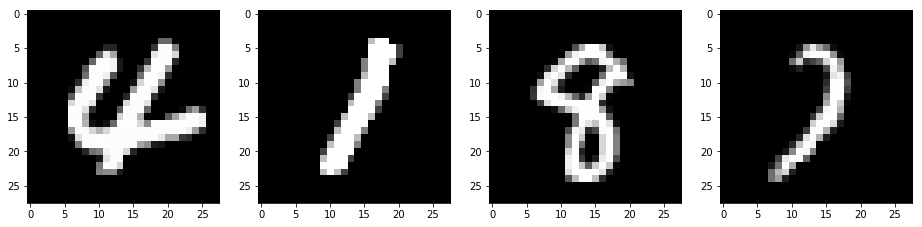

In [175]:
from matplotlib import pyplot as plt
import numpy as np
import json
with open("data/test.json", "r") as f:
  images = f.readlines()
plt.figure(figsize=(20,4))
for i, image in enumerate(images):
  if i < 4:
    image = json.loads(image)
    image = np.array(image['x'])
    plt.subplot(1, 5, i+1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

In [84]:
!ls /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/

flags.py      local_predict.py	models_util.py	      uploads.py
__init__.py   local_train.py	operations_util.py    versions_util.py
jobs_prep.py  local_utils.py	predict_utilities.py
jobs_util.py  log_utils.py	resources.yaml


In order to work with `Python 3`, delete the `*.pyc` files, see [post](https://stackoverflow.com/questions/48824381/gcloud-ml-engine-local-predict-runtimeerror-bad-magic-number-in-pyc-file)

Default Datalab
```
rm /tools/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
```
Default UNIX:
```
sudo rm /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
```

> Process running Datalab or Jupyter Notebook needs admin rights. This is not always given for locally run notebooks

In [ ]:
%%bash
# #remove any pyc files: Using Python3 you have to recompile
# #Note: you need admin rights
rm /tools/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
# sudo rm /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc 

In [179]:
%%bash
model_dir=$(ls $PWD/src/$PKG_NAME/trained/export/exporter/)
echo "Selected Model:  $model_dir"
gcloud ml-engine local predict \
    --model-dir=${PWD}/src/$PKG_NAME/trained/export/exporter/${model_dir} \
    --json-instances=./data/test.json \
    --verbosity debug

Selected Model:  1550248398
CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                    PROBABILITIES
[6]        [u'6']   [6.261812210083008, -1.336929440498352, 4.513674259185791, 0.6058327555656433, 12.668279647827148, 7.083803653717041, 12.901329040527344, 1.4406895637512207, 2.4258909225463867, 7.3969550132751465]     [0.0007261795690283179, 3.638752730239503e-07, 0.00012642622459679842, 2.539121624067775e-06, 0.4398833215236664, 0.001652077422477305, 0.5553280115127563, 5.851361038367031e-06, 1.567200706631411e-05, 0.0022595934569835663]
[1]        [u'1']   [-5.945840835571289, 40.77927780151367, 11.099405288696289, -1.9702718257904053, 12.539984703063965, 13.683131217956543, 1.515440821647644, 20.698762893676758, 24.271228790283203, -1.7380123138427734]  [5.099620982971267e-21, 0.9999998807907104, 1.2888283918831983e-13,

DEBUG: Running [gcloud.ml-engine.local.predict] with arguments: [--json-instances: "./data/test.json", --model-dir: "/home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/export/exporter/1550248398", --verbosity: "debug"]
2019-02-15 17:33:22.657580: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.

INFO: Display format: "default 
          table(
              predictions:format="table(
                  class_ids, classes, logits, probabilities
              )"
          )"
DEBUG: SDK update checks are disabled.


In [177]:
print(y_test)

[4 1 8 7]


In [ ]:
%%bash
gcloud ml-engine local predict --help

<h2> Running locally using gcloud </h2>

In [184]:
%%bash
# rm -rf taxifare.tar.gz taxi_trained
gcloud ml-engine local train \
   --module-name=${PKG_NAME}.task \
   --package-path=${PWD}/src/${PKG_NAME} \
   -- \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/src/${PKG_NAME}/trained \
   --train_steps=500 \
   --job_dir=./tmp

['dnn/head/beta1_power', 'dnn/head/beta2_power', 'dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adam', 'dnn/hiddenlayer_0/bias/t_0/Adam_1', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adam', 'dnn/hiddenlayer_0/kernel/t_0/Adam_1', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adam', 'dnn/hiddenlayer_1/bias/t_0/Adam_1', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adam', 'dnn/hiddenlayer_1/kernel/t_0/Adam_1', 'dnn/hiddenlayer_2/bias', 'dnn/hiddenlayer_2/bias/t_0/Adam', 'dnn/hiddenlayer_2/bias/t_0/Adam_1', 'dnn/hiddenlayer_2/kernel', 'dnn/hiddenlayer_2/kernel/t_0/Adam', 'dnn/hiddenlayer_2/kernel/t_0/Adam_1', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adam', 'dnn/logits/bias/t_0/Adam_1', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adam', 'dnn/logits/kernel/t_0/Adam_1', 'global_step']


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-02-15 18:30:07.129903: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-02-15 18:30:07.134765: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


### Visualise in TensorBoard

In [188]:
from google.datalab.ml import TensorBoard
TensorBoard().start(('{}/'+os.environ['PKG_NAME']).format(os.environ['PWD']))

ModuleNotFoundError: No module named 'google.datalab'

In [190]:
import tensorboard

In [193]:
dir(tensorboard.program)

['ABCMeta',
 'TensorBoard',
 'TensorBoardServer',
 'TensorBoardServerException',
 'WerkzeugServer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'absl_flags',
 'absolute_import',
 'abstractmethod',
 'application',
 'argparse',
 'argparse_flags',
 'base_plugin',
 'defaultdict',
 'division',
 'efi',
 'errno',
 'logger',
 'logging',
 'os',
 'print_function',
 'serving',
 'setup_environment',
 'socket',
 'sys',
 'threading',
 'util',
 'version']

In [194]:
from tensorboard.program import TensorBoard
TensorBoard().start(('{}/'+os.environ['PKG_NAME']).format(os.environ['PWD']))

TypeError: __init__() missing 2 required positional arguments: 'wsgi_app' and 'flags'

In [ ]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

If the above step (to stop TensorBoard) appears stalled, just move on to the next step. You don't need to wait for it to return.

<h2> Submit training job using gcloud </h2>

First copy the training data to the cloud.  Then, launch a training job.

After you submit the job, go to the cloud console (http://console.cloud.google.com) and select <b>Machine Learning | Jobs</b> to monitor progress.  

<b>Note:</b> Don't be concerned if the notebook stalls (with a blue progress bar) or returns with an error about being unable to refresh auth tokens. This is a long-lived Cloud job and work is going on in the cloud.  Use the Cloud Console link (above) to monitor the job.

In [ ]:
%bash
echo $BUCKET
gsutil -m rm -rf gs://${BUCKET}/$PKG_NAME/*
gsutil -m cp ${PWD}/data/mnist.npy gs://${BUCKET}/$PKG_NAME/

In [15]:
steps = 10000
batch_size = 128
n_train = 60000
print("Number of epochs using {} steps: {:.1f}".format(steps, steps * batch_size / n_train))
steps = int(60000 / 128 * 10) + 1
print("For ten epochs specify {} steps".format(steps))

Number of epochs using 10000 steps: 21.3
For ten epochs specify 4688 steps


In [21]:
%%bash
OUTDIR=gs://${BUCKET}/$PKG_NAME/trained
JOBNAME=mnist_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=$PKG_NAME.task \
   --package-path=${PWD}/src/$PKG_NAME \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --python-version 3.5 \
   --runtime-version=$TFVERSION \
   -- \
   --data_path="gs://${BUCKET}/$PKG_NAME/" \
   --output_dir=$OUTDIR \
   --train_steps=5000 \
   --job_dir=$OUTDIR/jobs 

gs://ml-productive-pipeline-53122/mnist_ml_engine/trained europe-west1 mnist_190213_091458
jobId: mnist_190213_091458
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [mnist_190213_091458] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe mnist_190213_091458

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs mnist_190213_091458


In [23]:
%%bash
gcloud ml-engine jobs describe    mnist_190213_091458
gcloud ml-engine jobs stream-logs mnist_190213_091458

createTime: '2019-02-13T09:15:01Z'
etag: vILgAPivuaI=
jobId: mnist_190213_091458
state: PREPARING
trainingInput:
  args:
  - --data_path=gs://ml-productive-pipeline-53122/mnist_ml_engine/
  - --output_dir=gs://ml-productive-pipeline-53122/mnist_ml_engine/trained
  - --train_steps=5000
  - --job_dir=gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/jobs
  packageUris:
  - gs://ml-productive-pipeline-53122/mnist_190213_091458/5bdda660e394bb7b04a29442d8a27a7ffe9afca2c9b3d9c159012832a00818d9/package_ml_engine-0.0.0.tar.gz
  pythonModule: package_ml_engine.mnist_ml_engine
  pythonVersion: '3.5'
  region: europe-west1
  runtimeVersion: '1.12'
trainingOutput: {}
INFO	2019-02-13 09:15:01 +0000	service		Validating job requirements...
INFO	2019-02-13 09:15:01 +0000	service		Job creation request has been successfully validated.
INFO	2019-02-13 09:15:01 +0000	service		Job mnist_190213_091458 is queued.
INFO	2019-02-13 09:15:01 +0000	service		Waiting for job to be provisioned.
INFO	2019-02-


View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/mnist_190213_091458?project=ml-productive-pipeline-53122

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fmnist_190213_091458&project=ml-productive-pipeline-53122


Don't be concerned if the notebook appears stalled (with a blue progress bar) or returns with an error about being unable to refresh auth tokens. This is a long-lived Cloud job and work is going on in the cloud. 

<b>Use the Cloud Console link to monitor the job and do NOT proceed until the job is done.</b>

<h2> Deploy model </h2>

Find out the actual name of the subdirectory where the model is stored and use it to deploy the model.  Deploying model will take up to <b>5 minutes</b>.

In [24]:
%%bash
gsutil ls gs://${BUCKET}/$PKG_NAME/trained/export/exporter

gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/export/exporter/
gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/export/exporter/1550049482/
gs://ml-productive-pipeline-53122/mnist_ml_engine/trained/export/exporter/1550049529/


In [25]:
%%bash
MODEL_NAME="MNIST_MLENGINE"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/$PKG_NAME/trained/export/exporter | tail -1)
echo "Run these commands one-by-one (the very first time, you'll create a model and then create a version)"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models   create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

Run these commands one-by-one (the very first time, you'll create a model and then create a version)


ERROR: (gcloud.ml-engine.models.create) Resource in project [ml-productive-pipeline-53122] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name
Creating version (this might take a few minutes)......
.....................................................................................................................done.


<h2> Prediction </h2>

In [33]:
%bash
gcloud ml-engine predict --model=MNIST_MLENGINE --version=v1 --json-instances=data/test.json

CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                                    PROBABILITIES
[8]        [u'8']   [-0.11568696796894073, -0.31675225496292114, -0.047930844128131866, 0.12332145869731903, -0.10088108479976654, -0.021981418132781982, -0.2649504244327545, -0.1047646552324295, 1.2383620738983154, 0.23731258511543274]  [0.07440567016601562, 0.06085335463285446, 0.0796218290925026, 0.09449440240859985, 0.0755155086517334, 0.08171500265598297, 0.06408874690532684, 0.07522281259298325, 0.28817883133888245, 0.10590385645627975]
[8]        [u'8']   [-0.02354954555630684, -0.2320529669523239, 0.17249378561973572, 0.24533908069133759, -0.16902874410152435, 0.01791192591190338, -0.08056589961051941, -0.10166634619235992, 1.4544720649719238, 0.2056676745414734]      [0.07270009070634842, 0.059017810970544815, 0.08844545483589172

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import json
with open("data/test.json", "r") as f:
  images = f.readlines()
plt.figure(figsize=(20,4))
for i, image in enumerate(images):
  if i < 4:
    image = json.loads(image)
    image = np.array(image['x'])
    plt.subplot(1, 5, i+1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

Unfortunatly, we do not have a True Positve. ToDO: Add more examples!

Get predictions using the [Python-Client-Library, see Tutorial](https://cloud.google.com/ml-engine/docs/tensorflow/python-client-library). Since we have created and deployed a model already, we use the [`predict`](https://cloud.google.com/ml-engine/reference/rest/v1/projects) Method instead of `create` as in the documentation. 

[API-Reference](https://cloud.google.com/ml-engine/reference/rest/)

If you need a service account authentification, please follow [this link]() and uncomment the celllines after this cell.

In [32]:
# %bash
# export GOOGLE_APPLICATION_CREDENTIALS=$PWD/ML-productive-pipeline-53122-64d3c31786e7.json
# echo $GOOGLE_APPLICATION_CREDENTIALS

In [49]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/datalab/proj_DL_models_and_pipelines_with_GCP/notebook/../ML-productive-pipeline-53122-64d3c31786e7.json'

In [28]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import json

In [3]:
%pdoc discovery.build

```
Signature: discovery.build(serviceName, version, http=None, discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', developerKey=None, model=None, requestBuilder=<class 'googleapiclient.http.HttpRequest'>, credentials=None, cache_discovery=True, cache=None)
Docstring:
Construct a Resource for interacting with an API.

Construct a Resource object for interacting with an API. The serviceName and
version are the names from the Discovery service.

Args:
serviceName: string, name of the service.
version: string, the version of the service.
http: httplib2.Http, An instance of httplib2.Http or something that acts
like it that HTTP requests will be made through.
discoveryServiceUrl: string, a URI Template that points to the location of
the discovery service. It should have two parameters {api} and
{apiVersion} that when filled in produce an absolute URI to the discovery
document for that service.
developerKey: string, key obtained from
https://code.google.com/apis/console.
model: googleapiclient.Model, converts to and from the wire format.
requestBuilder: googleapiclient.http.HttpRequest, encapsulator for an HTTP
request.
credentials: oauth2client.Credentials or
google.auth.credentials.Credentials, credentials to be used for
authentication.
cache_discovery: Boolean, whether or not to cache the discovery doc.
cache: googleapiclient.discovery_cache.base.CacheBase, an optional
cache object for the discovery documents.

Returns:
A Resource object with methods for interacting with the service.
File: /usr/local/envs/py3env/lib/python3.5/site-packages/googleapiclient/discovery.py
Type: function
```

In [29]:
api = discovery.build(serviceName='ml', version='v1',
                      http=None, 
                      discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', 
                      developerKey=None, 
                      model=None, 
                      #requestBuilder=<class 'googleapiclient.http.HttpRequest'>, 
                      credentials=None, 
                      cache_discovery=True, 
                      cache=None)

In [ ]:
api

In [30]:
MODEL_NAME = 'MNIST_MLENGINE'
VERSION = 'v1'

In [195]:
from src.pkg_mnist_fnn.utils import load_data
from src.pkg_mnist_fnn.model import parse_images
(_,_), (x_test, y_test) = load_data(rel_path='data')
N=4
test_indices = np.random.randint(low=0, high=len(y_test), size=N)
x_test, y_test = x_test[test_indices], y_test[test_indices]
x_test = parse_images(x_test).tolist()

eol = "\r\n"
n_lines = len(y_test)
instances = []
with open("data/test.json", "w") as f:
    for image, label in zip(x_test, y_test):
        instances.append({"x": image}) #, "y": int(label)}

Loaded data from /home/enryh/proj_DL_models_and_pipelines_with_GCP/data/mnist.npz


[{'x': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   75.0,
   184.0,
   217.0,
   35.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   4.0,
   60.0,
   105.0,
   240.0,
   221.0,
   37.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.

In [31]:
project_id = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION)
request_data = {"instances":
  [
   {"x": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3294117748737335, 0.7254902124404907, 0.6235294342041016, 0.5921568870544434, 0.23529411852359772, 0.1411764770746231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882430076599, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9450980424880981, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.6666666865348816, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26274511218070984, 0.4470588266849518, 0.2823529541492462, 0.4470588266849518, 0.6392157077789307, 0.8901960849761963, 0.9960784316062927, 0.8823529481887817, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9803921580314636, 0.8980392217636108, 0.9960784316062927, 0.9960784316062927, 0.5490196347236633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666667014360428, 0.25882354378700256, 0.054901961237192154, 0.26274511218070984, 0.26274511218070984, 0.26274511218070984, 0.23137255012989044, 0.08235294371843338, 0.9254902005195618, 0.9960784316062927, 0.4156862795352936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32549020648002625, 0.9921568632125854, 0.8196078538894653, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627451211214066, 0.9137254953384399, 1.0, 0.32549020648002625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823823928833, 0.9960784316062927, 0.9333333373069763, 0.1725490242242813, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137255012989044, 0.9764705896377563, 0.9960784316062927, 0.24313725531101227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.7333333492279053, 0.019607843831181526, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411926865578, 0.8039215803146362, 0.9725490212440491, 0.22745098173618317, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4941176474094391, 0.9960784316062927, 0.7137255072593689, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411765933036804, 0.9843137264251709, 0.9411764740943909, 0.2235294133424759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980693101883, 0.8666666746139526, 0.9960784316062927, 0.6509804129600525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0117647061124444, 0.7960784435272217, 0.9960784316062927, 0.8588235378265381, 0.13725490868091583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901961386203766, 0.9960784316062927, 0.9960784316062927, 0.3019607961177826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862765550613, 0.8784313797950745, 0.9960784316062927, 0.45098039507865906, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.239215686917305, 0.9490196108818054, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.9960784316062927, 0.8588235378265381, 0.1568627506494522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.8117647171020508, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
  ]
}
request = api.projects().predict(body=request_data, name=project_id).execute()
print(request)

{'predictions': [{'class_ids': [8], 'classes': ['8'], 'logits': [-0.11568695306777954, -0.31675225496292114, -0.047930844128131866, 0.12332145869731903, -0.10088106244802475, -0.021981418132781982, -0.2649504244327545, -0.10476464033126831, 1.2383620738983154, 0.23731258511543274], 'probabilities': [0.07440567761659622, 0.06085335463285446, 0.0796218290925026, 0.09449440240859985, 0.0755155086517334, 0.08171500265598297, 0.06408874690532684, 0.07522281259298325, 0.28817883133888245, 0.10590385645627975]}]}
